# Gillespie Algorithm example
Taken from https://lewiscoleblog.com/gillespie-algorithm

## Background
In the sciences a master equation represents the time evolution properties of a multi-state jumping system, by which we mean a system that "jumps" between distinct states through time (in contrast a "diffusion system" varies gradually). The system in question being stochastic in nature we are concerned with observing how the state distribution varies over time, for example: with some initial condition what is the probability of finding the system in a particular state within the next X seconds/minutes/years? Of course the time units depend on the nature of the system (e.g. if we construct a master equation for predator/prey dynamics we are unlikely to be interested in microsecond timescales, however if looking at a chemical reaction we are unlikely to find a timescale in days useful.) If we want to display the master equation mathematically we use a transition rate matrix $A(t)$ - this can evolve in time or it can be static.

We can then express the master equation in the form:

$$
\frac{d\mathbf{P}_t}{dt} = A(t) \mathbf{P}_t
$$

where vector $\mathbf{P}_t$ represents the probability distribution of states at time $t$ - obscured by notation is an initial condition. Those from a mathematical or probabilistic background will recognise this as a Kolmogorov backwards equation for jump processes. If we expand the notation a little such that $P_{ij}(s,t)$ represents the probability of the system being in state $i$ at time $s$ and state $j$ at time $t$ then we can note that the transition rate matrix satisfies:

\begin{align*}
A_{ij}(t) &= \bigg[ \frac{∂P_{ij}(t,u)}{du} \bigg]_{u=t} \\
A_{ij}(t) &≥ 0 & ∀i ≠ j \\
∑_jA_{ij}(t) &= 0 & ∀i
\end{align*}

Further we can note that if there is a distribution $π$ such that:

$$
\pi_j A_{ij}(t) = \pi_i A_{ij}(t)
$$

For all pairs of states $(i,j)$ then the process satisfies detailed balance and the process is a reversible Markov process.

## Algorithm example
To illustrate the algorithm in action we will take a simple reaction. We will have following forward reaction

\begin{align*}
A+B→AB
\end{align*}

Where two monomers $A$ and $B$ react to form a dimer $AB$. The corresponding reverse reaction being:

\begin{align*}
AB→A+B
\end{align*}

We will denote the rate of the forward reaction to be $r_f$ and the rate of the backward reaction to be $r_b$. If we let the number of molecules present be denoted by $N_A$, $N_B$, and $N_{AB}$, then the rate of any reaction occurring is:

\begin{align*}
R = r_f N_A N_B + r_b N_{AB}
\end{align*}

Also given a reaction has occured the probability of the forward reaction having taken place is:

\begin{align*}
P(A+B→AB)= \frac{r_f N_A N_B}{R}
\end{align*}​

For a model such as this we typically want to remove any "path dependence" - the arrival of the next reaction event is independent of reactions that have occurred previously (given the concentration of reactants). To satisfy this constraint typically reactions events are taken to follow a Poisson process. Under this assumption the number of reactions occuring within a time period $ΔT$ follows a $Poisson(RΔT)$ distribution. Moreover the time between reactions is then follows an exponential distribution. Thus if we sample $u∼U[0,1]$ then we take the time until next reaction to be $τ= \frac{1}{R}ln(\frac{1}{u})$. (Note: here I have used that $U$ and $1−U$ have the same distribution).

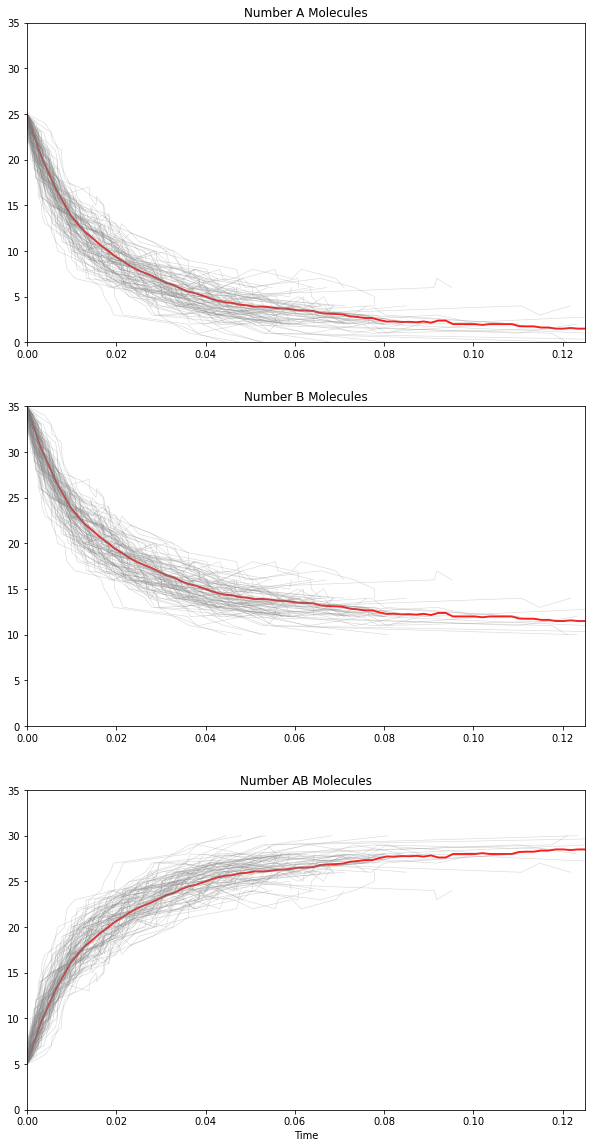

In [ ]:
# An implenetation of the Gillespie algorithm
# applied to a pair of reactions:
# A + B -> AB
# AB -> A + B

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fix random seed for repeatability
np.random.seed(123)

###### Fix model parameters ######
N_A0 = 25     # Initial number of A molecules
N_B0 = 35     # Initial number of B molecules
N_AB0 = 5     # Initial number of AB molecules

rf = 2        # Forward reaction rate
rb = 1        # Backwards reaction rate

steps = 25    # Number of reactions per trajectory
cycles = 100  # Number of trajectories iterated over

# Set up holder arrays
T = np.zeros((cycles, steps+1))
N_A = np.zeros((cycles, steps+1))
N_B = np.zeros((cycles, steps+1))
N_AB = np.zeros((cycles, steps+1))

# Store initial conditions
N_A[:,0] = N_A0
N_B[:,0] = N_B0
N_AB[:,0] = N_AB0

###### Main Code Loop ######
for i in range(cycles):
    for j in range(steps):
        # Calculate updated overall reaction rate
        R = rf * N_A[i,j] * N_B[i,j] + rb * N_AB[i,j]
        
        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1/R * np.log(1/u1)
        
        # Store reaction time
        T[i, j+1] = T[i,j] + tau
        
        # Select which reaction to occur
        Rf = rf * N_A[i,j] * N_B[i,j] / R
        u2 = np.random.random()
        
        # Update populations
        if u2 < Rf:
            N_A[i,j+1] = N_A[i,j] - 1
            N_B[i,j+1] = N_B[i,j] - 1
            N_AB[i,j+1] = N_AB[i,j] + 1
        else:
            N_A[i,j+1] = N_A[i,j] + 1
            N_B[i,j+1] = N_B[i,j] + 1
            N_AB[i,j+1] = N_AB[i,j] - 1

# Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_A_ave = np.zeros(ave_steps+1)
N_B_ave = np.zeros(ave_steps+1)
N_AB_ave = np.zeros(ave_steps+1)

N_A_ave[0] = N_A0
N_B_ave[0] = N_B0
N_AB_ave[0] = N_AB0

# Pass over average array entries
for i in range(1, ave_steps+1):
    tmax = T_ave[i]
    A_sum = 0
    B_sum = 0
    AB_sum = 0
    t_count = 0
    
    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j,k] <= tmax and T[j,k+1] > tmax:
                t_count += 1
                A_sum += N_A[j,k]
                B_sum += N_B[j,k]
                AB_sum += N_AB[j,k]
    
    # Caclulate average - taking care if no samples observed
    if t_count == 0:
        N_A_ave[i] = N_A_ave[i-1]
        N_B_ave[i] = N_B_ave[i-1]
        N_AB_ave[i] = N_AB_ave[i-1]
    else:
        N_A_ave[i] = A_sum / t_count
        N_B_ave[i] = B_sum / t_count
        N_AB_ave[i] = AB_sum / t_count


###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(10,20))

# Plot average trajectories
axs[0].plot(T_ave, N_A_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number A Molecules')
axs[0].set_ylim((0,35))
axs[0].set_xlim((0,0.125))
axs[1].plot(T_ave, N_B_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number B Molecules')
axs[1].set_ylim((0,35))
axs[1].set_xlim((0,0.125))
axs[2].plot(T_ave, N_AB_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[2].set_title('Number AB Molecules')
axs[2].set_xlabel("Time")
axs[2].set_ylim((0,35))
axs[2].set_xlim((0,0.125))

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(T[i,:], N_A[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[1].plot(T[i,:], N_B[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    axs[2].plot(T[i,:], N_AB[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)

plt.show()

In these plots we can see the various trajectories along with their average. If we increase the number of molecules and the number of trajectories we can get a "smoother" plot. Since we have the full evolution of the system we can also look at some other statistics, for example let's suppose we are interested in the distribution in the number of molecules of each type at time 0.5. We can also plot this using our samples:

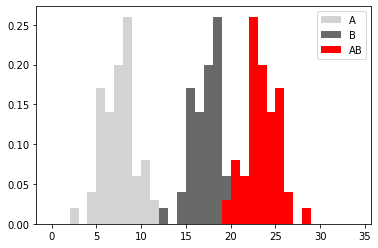

In [ ]:
time = 0.025
N_A_time = np.zeros(cycles)
N_B_time = np.zeros(cycles)
N_AB_time = np.zeros(cycles)

for i in range(cycles):
    for j in range(1, steps):
        if T[i,j] >= time and T[i,j-1] < time:
            N_A_time[i] = N_A[i,j]
            N_B_time[i] = N_B[i,j]
            N_AB_time[i] = N_AB[i,j]
    # If trajectory doesn't span far enough take latest observation
    if T[i, steps] < time:
        N_A_time[i] = N_A[i, steps]
        N_B_time[i] = N_B[i, steps]
        N_AB_time[i] = N_AB[i, steps]

plt.hist(N_A_time, density=True, bins=np.arange(35), label="A", color='lightgrey')
plt.hist(N_B_time, density=True, bins=np.arange(35), label="B", color='dimgrey')
plt.hist(N_AB_time, density=True, bins=np.arange(35), label="AB", color='red')
plt.legend()
plt.show()

If instead of a system of 2 reactions we instead wanted to look a system of a large number of reactions we could modify the method above quite simply. Instead of the calculation of $R$ (overall reaction rate) consisting of 2 terms it will consist of a larger number of terms depending on the nature of the individual reactions. The probability of selecting a particular reaction type would then equally be in proportion to their contribution to $R$.

We can also notice that there is nothing "special" about the method that means it only applies to reaction kinetics. For example: the example code above could equally be a "marriage and divorce model" for heterosexual couples: $A$ representing women and $B$ representing men, $AB$ representing a marriage. Through defining the "reactions" slightly differently it doesn't take much modification to turn this into a infection model: for example there could be 3 states: susceptible to infection, infected and recovered (potentially with immunity) with transition rates between each of these states.

We can see then that the Gillespie algorithm is very flexible and allows us to model stochastic systems that may otherwise be mathematically intractable. Through the nature of the modelling procedure we can sample from the system exactly (upto the precision of floating point numbers within our computers!)